# OCR

**Group:** 2

**Members:** Yoann Loial - Victor Mader - Tristan Chaput

**Output metrics:** Text from pictures, lang detection and sentiment analysis.

In [24]:
# Generic Libraries
from PIL import Image
import os
import re
import numpy as np 

# Tesseract Library
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = (r'C:\Program Files\Tesseract-OCR\tesseract')

# Opencv Library
import cv2

# Plotting Libraries
import matplotlib.pyplot as plt

# ML Libraries
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd


In [25]:
plt.close("all")
pd.set_option('display.max_columns', 500)
df_imdb_movies = pd.read_csv('./data/IMDb movies.csv', header=0, delimiter=',')
df_train = pd.read_csv('./data/Multi_Label_dataset/train.csv', header=0, delimiter=',')

### Function for text extraction

In [26]:
def text_extraction(img):
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Performing OTSU threshold
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

    # Applying dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    text = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Drawing a rectangle on copied image
        rect = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Cropping the text block for giving input to OCR
        cropped = img[y:y + h, x:x + w]

        # Apply OCR on the cropped image
        text.append(pytesseract.image_to_string(cropped))

    return ' '.join(text)

### Image processing

In [27]:
poster_directory = './data/Movie_Poster_Dataset/Movie_Poster_Dataset/'

path, dirs, files = next(os.walk(poster_directory))
total_files = 0
data = {'directory': [], 'file': [], 'text': []}

for dir in dirs:
    subpath, subdir, subfiles = next(os.walk(path+dir+'/'))
    for index, subfile in enumerate(subfiles):
        filepath = subpath + os.sep + subfile
        data['directory'].append(dir)
        data['file'].append(subfile)
        img = cv2.imread(filepath)
        text = text_extraction(img)
        if not text:
            data['text'].append(None)
        else:   
            data['text'].append(text)

df_files = pd.DataFrame(data=data)

In [28]:
df_files = df_files.dropna()

In [29]:
df_files

,directory,file,text
1,1980,tt0079302.jpg,KIRK DOUGLAS NANCYALLEN VINCENTGARDENA =\n\n
2,1980,tt0080339.jpg,en ease at\nPAN oe AH PN PE\n\ni wi\n‘i SER #\n\n
3,1980,tt0080360.jpg,
4,1980,tt0080365.jpg,
6,1980,tt0080402.jpg,"RmsNare ame, LE RINyA DAKE\n\nTHE AWAKENING\n\n"
...,...,...,...
8028,2015,tt4935446.jpg,
8032,2015,tt5022418.jpg,V.y.: | foe\n
8033,2015,tt5049302.jpg,rayon anKS0-2a\n\n
8035,2015,tt5105784.jpg,FREE SPEECH\nAPOCALYPSE\n\n


In [30]:
df_files.to_csv('df_files.csv',sep=',')

In [34]:
df_files = pd.read_csv('./df_files.csv', header=0, delimiter=',')

### Text cleaning

In [35]:
nlp = spacy.load("en_core_web_sm")
stops = nlp.Defaults.stop_words

def normalize(comment, lowercase, remove_stopwords, lemma, nlp):
    comment = re.sub(r'[^\w]', ' ', comment)
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

df_files['text_clean'] = df_files['text'].apply(
    normalize, lowercase=True, remove_stopwords=True, lemma=True, nlp=nlp)

df_files

,Unnamed: 0,directory,file,text,text_clean
0,1,1980,tt0079302.jpg,KIRK DOUGLAS NANCYALLEN VINCENTGARDENA =\n\n,kirk douglas nancyallen vincentgardena
1,2,1980,tt0080339.jpg,en ease at\nPAN oe AH PN PE\n\ni wi\n‘i SER #\n\n,en ease pan oe ah pn pe wi I ser
2,3,1980,tt0080360.jpg,,
3,4,1980,tt0080365.jpg,,
4,6,1980,tt0080402.jpg,"RmsNare ame, LE RINyA DAKE\n\nTHE AWAKENING\n\n",rmsnare ame le rinya dake awakening
...,...,...,...,...,...
5328,8028,2015,tt4935446.jpg,,
5329,8032,2015,tt5022418.jpg,V.y.: | foe\n,v y foe
5330,8033,2015,tt5049302.jpg,rayon anKS0-2a\n\n,rayon anks0 2a
5331,8035,2015,tt5105784.jpg,FREE SPEECH\nAPOCALYPSE\n\n,free speech apocalypse


### Lang detection

In [37]:
import langid
from langid.langid import LanguageIdentifier, model
lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

langid_preds = [lang_identifier.classify(text)[0] for text in df_files['text_clean']]

df_files['lang'] = langid_preds

df_files

,Unnamed: 0,directory,file,text,text_clean,lang
0,1,1980,tt0079302.jpg,KIRK DOUGLAS NANCYALLEN VINCENTGARDENA =\n\n,kirk douglas nancyallen vincentgardena,nl
1,2,1980,tt0080339.jpg,en ease at\nPAN oe AH PN PE\n\ni wi\n‘i SER #\n\n,en ease pan oe ah pn pe wi I ser,en
2,3,1980,tt0080360.jpg,,,en
3,4,1980,tt0080365.jpg,,,en
4,6,1980,tt0080402.jpg,"RmsNare ame, LE RINyA DAKE\n\nTHE AWAKENING\n\n",rmsnare ame le rinya dake awakening,rw
...,...,...,...,...,...,...
5328,8028,2015,tt4935446.jpg,,,en
5329,8032,2015,tt5022418.jpg,V.y.: | foe\n,v y foe,es
5330,8033,2015,tt5049302.jpg,rayon anKS0-2a\n\n,rayon anks0 2a,en
5331,8035,2015,tt5105784.jpg,FREE SPEECH\nAPOCALYPSE\n\n,free speech apocalypse,en


### Plot lang detection

<AxesSubplot:xlabel='lang'>

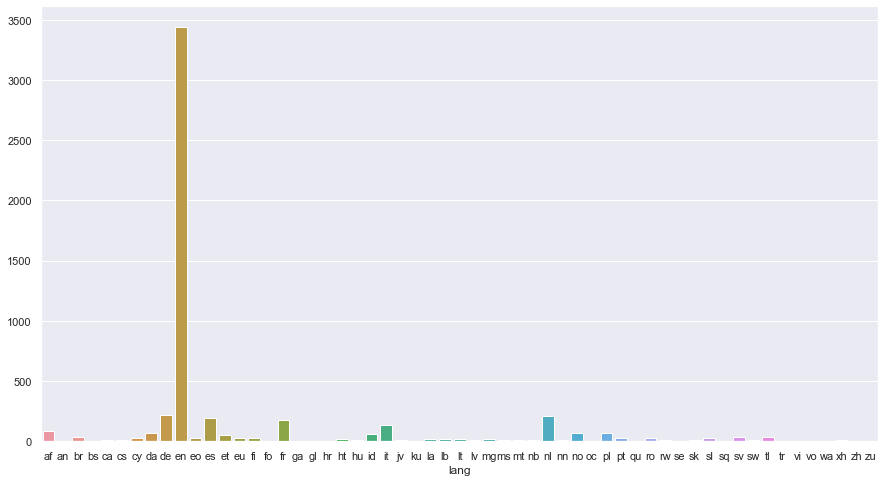

In [47]:
import seaborn as sns

sentiment_count = df_files.groupby('lang').size()

# plot the result
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = sentiment_count.index, y = sentiment_count.values)

### Sentiment analysis

In [38]:
def sentiment_analyzer(text, nlp):
    # decide sentiment as positive, negative and neutral 
    doc = nlp(text)
    polarity = doc._.blob.polarity

    if polarity > 0.00 : 
        return "Positive" 
  
    elif polarity < 0.00 : 
        return "Negative" 
  
    else : 
        return "Neutral"

nlp.add_pipe('spacytextblob')

df_files['sentiment'] = df_files['text_clean'].apply(lambda x: sentiment_analyzer(x, nlp))

df_files

,Unnamed: 0,directory,file,text,text_clean,lang,sentiment
0,1,1980,tt0079302.jpg,KIRK DOUGLAS NANCYALLEN VINCENTGARDENA =\n\n,kirk douglas nancyallen vincentgardena,nl,Neutral
1,2,1980,tt0080339.jpg,en ease at\nPAN oe AH PN PE\n\ni wi\n‘i SER #\n\n,en ease pan oe ah pn pe wi I ser,en,Neutral
2,3,1980,tt0080360.jpg,,,en,Neutral
3,4,1980,tt0080365.jpg,,,en,Neutral
4,6,1980,tt0080402.jpg,"RmsNare ame, LE RINyA DAKE\n\nTHE AWAKENING\n\n",rmsnare ame le rinya dake awakening,rw,Neutral
...,...,...,...,...,...,...,...
5328,8028,2015,tt4935446.jpg,,,en,Neutral
5329,8032,2015,tt5022418.jpg,V.y.: | foe\n,v y foe,es,Neutral
5330,8033,2015,tt5049302.jpg,rayon anKS0-2a\n\n,rayon anks0 2a,en,Neutral
5331,8035,2015,tt5105784.jpg,FREE SPEECH\nAPOCALYPSE\n\n,free speech apocalypse,en,Positive


### Plot sentiment analysis

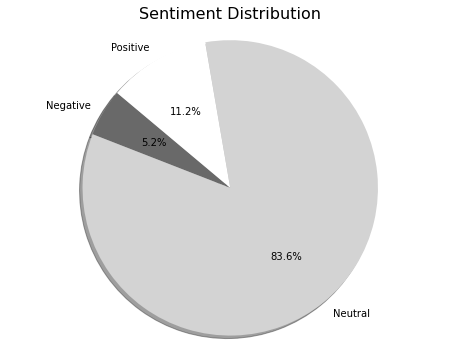

In [33]:
sentiment_count = df_files.groupby('sentiment').size()

# Data to plot
labels = 'Negative', 'Neutral', 'Positive'
sizes = [sentiment_count[0], sentiment_count[1], sentiment_count[2]]
colors = ['dimgrey', 'lightgray', 'white']
fig = plt.figure(figsize=[8, 6])

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Sentiment Distribution", fontsize=16)
plt.show()